In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from collections import Counter
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### We dont know true cluster labels. In this case we can use [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for calculating score of clusterization. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [2]:
COLUMNS_TO_DROP = ['_id', 'year', 'n_citation', 'references', 'authors']
NUM_PARTS = 3
RANDOM_STATE = 42
REDUCED_DIMENSION = 60
NUM_CLUSTERS = 50

def plot_clusters(cluster_ids, cluster_sizes, cluster_names):
    plt.figure(figsize=(18, 7))
    plt.bar(cluster_ids, cluster_sizes)
    plt.xlabel('Cluster id')
    plt.xticks(range(NUM_CLUSTERS))
    plt.title('Cluster sizes')
    ax = plt.gca()
    for bar, word in zip(ax.patches, cluster_names):
        ax.text(bar.get_x() + bar.get_width() / 4, bar.get_y() + bar.get_height()*1.05, word, rotation='vertical', color = 'black', va = 'bottom', fontsize=10) 
    plt.show()

def get_score(X, cluster_labels, sample_size=10000):
    return silhouette_score(X, pipe['kmeans'].labels_, sample_size=sample_size, random_state=RANDOM_STATE)

def get_text_data(file_path):
    data = pd.read_json('data/part_1_clean.json', dtype={'title': 'string', 'abstract': 'string'}).drop(COLUMNS_TO_DROP, axis=1)
    data['keywords'] = data['keywords'].apply(lambda row: ' '.join(row)).astype('string')
    data['fos'] = data['fos'].apply(lambda row: ' '.join(row)).astype('string')
    data['venue'] = data['venue'].apply(lambda row: row.get('name_d', '')).astype('string')
    
    data['text'] = data.apply(lambda row: ' '.join(row.astype(str)), axis=1).astype('string')
    data.drop(['title', 'abstract', 'venue'], axis=1, inplace=True)
    return data

### Time consuming cell below: 3 parts are loaded, transformed and concatenated together.

In [3]:
# articles = pd.concat(get_text_data(f'data/part_{i}_clean.json') for i in range(NUM_PARTS))
# articles.reset_index(drop=True, inplace=True)
articles = pd.read_json('articles.json')

articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534806 entries, 0 to 1534805
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   keywords  1534806 non-null  object
 1   fos       1534806 non-null  object
 2   text      1534806 non-null  object
dtypes: object(3)
memory usage: 46.8+ MB


In [4]:
articles

,keywords,fos,text
0,handwriting recognition prototypes image segme...,Intelligent character recognition Pattern reco...,A solution to the problem of touching and brok...
1,sequential circuits statistical distributions ...,Delay calculation Timing failure Monte Carlo m...,Timing yield estimation using statistical stat...
2,Internet hypermedia markup languages informati...,XML Base World Wide Web XML framework XML Encr...,Using XML to Integrate Existing Software Syste...
3,cognition multi-agent systems ubiquitous compu...,Syma Computer science Symbiotic computing Mult...,The design of awareness and operation module f...
4,balanced scorecard,Lease Computer science Balanced scorecard Busi...,A Model for Evaluating the Effectiveness of th...
...,...,...,...
1534801,data mining probability density function montg...,Integer Cryptography Modular arithmetic Parall...,Modular Reduction without Precomputational Pha...
1534802,particle filters video tracking data fusion in...,Computer vision Space technology Identifier In...,Video-radio fusion approach for target trackin...
1534803,visualization load balancing parallel processi...,Computer architecture Visualization Load balan...,Survey of parallel approaches to scientific vi...
1534804,parallel distributed compensation scheme lyapu...,Lyapunov function Stability criterion Mathemat...,Stability Analysis of Time-Delay Fuzzy Systems...


### Applying [Porter stemming](https://www.nltk.org/api/nltk.stem.porter.html) to normalize text data

In [5]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [6]:
%%time
articles = articles.parallel_applymap(porter.stem)

CPU times: total: 22.3 s
Wall time: 1min 39s


In [7]:
articles

,keywords,fos,text
0,handwriting recognition prototypes image segme...,intelligent character recognition pattern reco...,a solution to the problem of touching and brok...
1,sequential circuits statistical distributions ...,delay calculation timing failure monte carlo m...,timing yield estimation using statistical stat...
2,internet hypermedia markup languages informati...,xml base world wide web xml framework xml encr...,using xml to integrate existing software syste...
3,cognition multi-agent systems ubiquitous compu...,syma computer science symbiotic computing mult...,the design of awareness and operation module f...
4,balanced scorecard,lease computer science balanced scorecard busi...,a model for evaluating the effectiveness of th...
...,...,...,...
1534801,data mining probability density function montg...,integer cryptography modular arithmetic parall...,modular reduction without precomputational pha...
1534802,particle filters video tracking data fusion in...,computer vision space technology identifier in...,video-radio fusion approach for target trackin...
1534803,visualization load balancing parallel processi...,computer architecture visualization load balan...,survey of parallel approaches to scientific vi...
1534804,parallel distributed compensation scheme lyapu...,lyapunov function stability criterion mathemat...,stability analysis of time-delay fuzzy systems...


In [85]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english')
svd = TruncatedSVD(n_components=REDUCED_DIMENSION, random_state=RANDOM_STATE)
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)

pipe = Pipeline([
    ('tfidf', vectorizer),
    ('svd', svd),
    ('kmeans', kmeans)
])

In [86]:
pipe.fit(articles.text)

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

In [87]:
articles_compressed = pipe[:-1].transform(articles.text)
print(articles_compressed.shape)

(1534806, 60)


In [89]:
print('Score:', get_score(articles_compressed, kmeans.labels_))  #n_com=100 0.06735451976061607

Score: 0.11844327048389382


### Cluster names based on tfidf score of cluster centers

In [90]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
cluster_names = terms[order_centroids[:, 0]]

topK = 5
for i in range(NUM_CLUSTERS):
    print(f'Cluster {i}: ', end='')
    print(' '.join(terms[order_centroids[i, :topK]]))

Cluster 0: game games video human search
Cluster 1: parallel computing algorithm distributed programming
Cluster 2: logic programming temporal gate circuit
Cluster 3: decision tree support trees making
Cluster 4: graph graphs mathematics discrete combinatorics
Cluster 5: web semantic service world wide
Cluster 6: database xml query data relational
Cluster 7: user interface interaction human virtual
Cluster 8: routing protocol network hoc ad
Cluster 9: data mining database information analysis
Cluster 10: filter noise signal processing frequency
Cluster 11: service services web quality architecture
Cluster 12: segmentation image object vision recognition
Cluster 13: learning machine artificial intelligence supervised
Cluster 14: robot robots mobile control planning
Cluster 15: fuzzy logic set control neuro
Cluster 16: security authentication key privacy information
Cluster 17: language programming natural object formal
Cluster 18: neural network artificial networks learning
Cluster 19: 

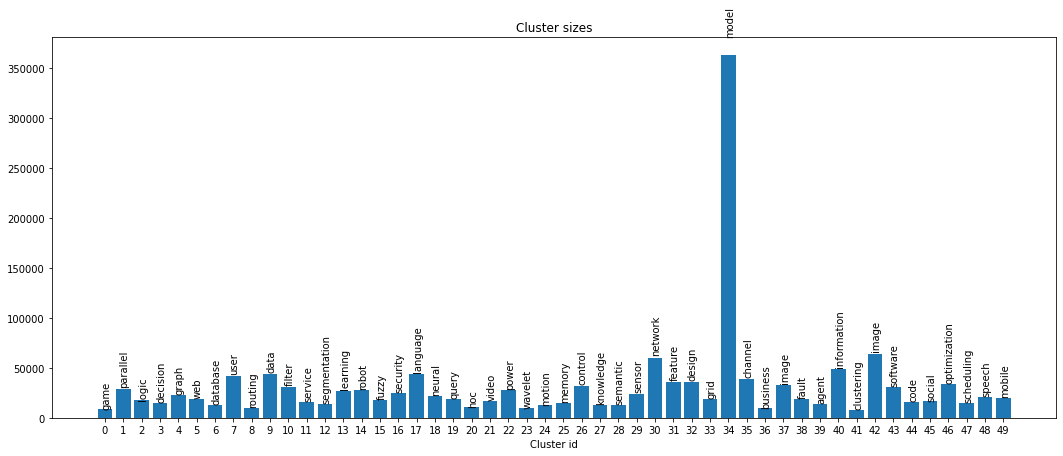

In [91]:
plot_clusters(cluster_ids, cluster_sizes, cluster_names)

### Cluster names based on top words from `keyrowds` + `fos`

In [92]:
cluster_names_counter = []

for cluster_id in range(NUM_CLUSTERS):
    cluster = articles.loc[np.argwhere(kmeans.labels_ == cluster_id).flatten()]
    c = Counter(' '.join((cluster.keywords + ' ' + cluster.fos).values).split())
    print(f'Cluster {cluster_id}: ', end='')
    top_words = c.most_common(topK)
    print(' '.join(pair[0] for pair in top_words))
    cluster_names_counter.append(top_words[0][0])

Cluster 0: game computer design science theory
Cluster 1: parallel computer computing science algorithm
Cluster 2: logic computer science programming temporal
Cluster 3: decision tree system computer science
Cluster 4: graph mathematics combinatorics computer discrete
Cluster 5: web computer science world wide
Cluster 6: database xml data computer science
Cluster 7: user computer interface interaction science
Cluster 8: routing protocol network computer wireless
Cluster 9: data computer science mining system
Cluster 10: filter noise signal algorithm computer
Cluster 11: service web computer science architecture
Cluster 12: segmentation image computer artificial intelligence
Cluster 13: learning computer science artificial machine
Cluster 14: robot control mobile computer robots
Cluster 15: fuzzy set control system logic
Cluster 16: security computer science information authentication
Cluster 17: language programming computer science natural
Cluster 18: neural network artificial compute

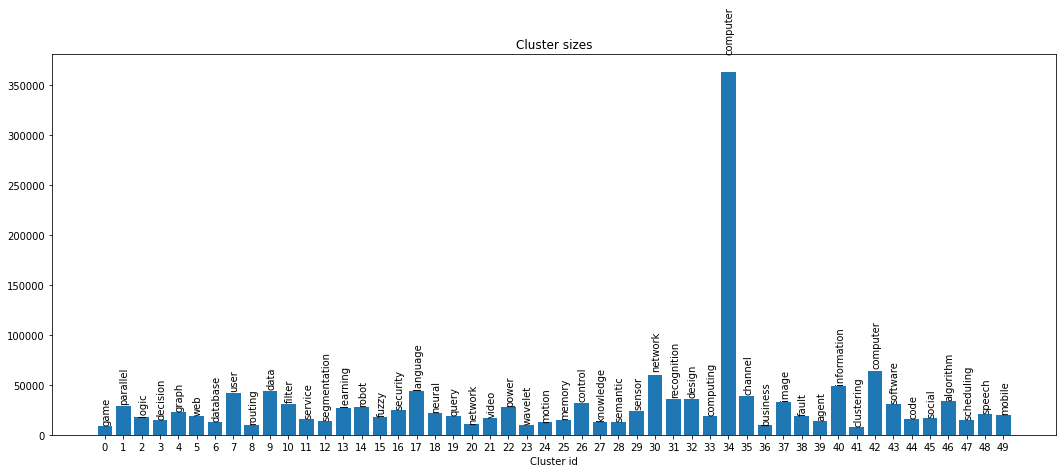

In [93]:
plot_clusters(cluster_ids, cluster_sizes, cluster_names_counter)